## Preterm birth prediction based on gene expression from blood

### Introduction
[DREAM Preterm Birth Prediction](https://www.synapse.org/#!Synapse:syn18380862/wiki/590485) - Challenge on Synapse.org platform (sub-challenge 2).

Preterm delivery is defined as giving birth prior to completion of 37/40 weeks of gestatation.
Predictions are made for two conditions - **sPTD**, which stands for spontaneous preterm delivery due to preterm labor and **PPROM**, which stands for premature rupture of membranes, both resulting in preterm birth.

### Data

Data provided is coming from two platforms (Affymetrix HTA20, Affymetrix HG 2.1 ST Array), in a form of gene expression matrices. Both platforms use a microarray technology for estimating gene expression from blood samples of asymptomatic pregnant women. More on microarray technology [here](https://www.mrc-lmb.cam.ac.uk/genomes/madanm/microarray/chapter-final.pdf)

The data available for this challenge include around 29k genes, from 435 samples. 
Each individual has two or more samples taken in different GA periods.

The data provided by the challenge is pre-split into train and test set, where the test set did not have the data about the delivery outcome, since it was required for the challenge participants to predict probabilities for each individual pregnancy resulting in sPTD/PPROM. 

For our purposes, we will evaluate our models using the train data provided by the Synapse challenge, and split it into train/test sets using cross-validation, so that the models can be evaluated using the scoring metrics.

### Procedure

**Loading data** - Data from two different platforms is loaded (```eset_HuGene21ST.csv```, ```HTA20_RMA.csv```) in a form of matrices where rows are ```GeneID```s and columns are ```SampleID```s. Also, ```anoSC2_v20_nokey.csv``` is provided, which contains the data about the samples, such as GA, IndividualID, Group (denoting delivery outcome - can be Control, sPTD or PPROM), etc. Data used for this script can be found [here](https://drive.google.com/drive/folders/1pIMBCzIHzBL4ffNiuDOTGdbrlLyLSlMx?usp=sharing)

**Preprocessing** - the data was preprocessed by merging the gene expression matrices from two platforms. Merging was performed using inner join of the two matrices on genes. Afterwards, the data was scaled using the StandardScaler which transforms the data by subtracting the mean value of a single gene expression across all samples and then dividing it by standard deviation.

**Extracting relevant data & gene selection** - There were two main obstacles: choosing the right heuristic for evaluating samples from the same pregnant woman and reducing the gene set from 29k to 50 most important per condition (sPTD, PPROM). 
The simplest solution for the first problem was to observe only the latest blood sample (GA closest to delivery date). This approach gave a good results of the model predictions, so the data set was reduced to use only one sample per woman. Other approaches on this include calculating difference between gene expressions in the earliest and latest GA periods, but it is not certain that these differences will be greater moving to later GA periods or that the data set will consist of samples taken in larger GA intervals.
The solution for the gene selection included extracting 100 (50 sPTD vs Control, 50 PPROM vs Control) most important features evaluated by the ```Lasso``` model.

**Making predictions and evaluations using cross-validation** - After the data was reduced, ```LogisticRegression``` model was trained and tested using 5-fold cross-validation. The results are plotted for the following scoring metrics: ```recall_score, precision_score, roc_auc_score, f1_score, auc_precision_score``` 

In [18]:
# !pip install pandas
# !pip install scikit-plot

In [5]:
import numpy as np
import pandas as pd

In [6]:
print("Loading data...")
patients_data = pd.read_csv('preterm_data/anoSC2_v20_nokey.csv')
platform1_data = pd.read_csv('preterm_data/eset_HuGene21ST.csv')
platform2_data = pd.read_csv('preterm_data/HTA20_RMA.csv')
print("Data successfully loaded.")

Loading data...
Data successfully loaded.


In [7]:
print("Merging data from different platforms...")
platform1_data.columns = ['GeneID'] + platform1_data.columns.tolist()[1:]
platform2_data.columns = ['GeneID'] + platform2_data.columns.tolist()[1:]

common_genes = list(set(platform1_data.GeneID.values).intersection(set(platform2_data.GeneID.values)))

platform1_data = platform1_data[platform1_data.GeneID.isin(common_genes)]
platform2_data = platform2_data[platform2_data.GeneID.isin(common_genes)]

merged = pd.merge(platform1_data, platform2_data, on='GeneID', how='inner')
cols = ['GeneID'] + patients_data.SampleID.tolist()
merged = merged[cols]
print("Data successfully merged.")

Merging data from different platforms...
Data successfully merged.


In [8]:
print("Scaling data...")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(merged.T.values[1:])
transformed_data = pd.DataFrame(data=scaled_features.T, columns=merged.columns.tolist()[1:], index=merged.index.tolist())
transformed_data["GeneID"] = merged.GeneID.tolist()
print("Data successfully scaled.")

Scaling data...
Data successfully scaled.


In [9]:
print("Extracting sPTD/Control and PPROM/Control train samples..")
sPTD_samples = patients_data[patients_data["Group"].isin(["Control", "sPTD"]) & (patients_data["Train"] == 1)].SampleID.values
PPROM_samples = patients_data[patients_data["Group"].isin(["Control", "PPROM"]) & (patients_data["Train"] == 1)].SampleID.values
print("Samples extracted.")

Extracting sPTD/Control and PPROM/Control train samples..
Samples extracted.


In [10]:
print("Fetching latest sPTD & PPROM data, per one person...")
def get_latest_data_for(data_set):
    result = pd.DataFrame()
    for individual_id in pd.unique(data_set.IndividualID):
        latest_sample_data = data_set[data_set.IndividualID == individual_id].sort_values('GA').iloc[-1:]
        result = result.append(latest_sample_data)
    return result
    
sPTD_data = patients_data[patients_data["SampleID"].isin(sPTD_samples)]
latest_sptd_data = get_latest_data_for(sPTD_data)

PPROM_data = patients_data[patients_data["SampleID"].isin(PPROM_samples)]
latest_pprom_data = get_latest_data_for(PPROM_data)
print("Latest data fetched.")

Fetching latest sPTD & PPROM data, per one person...
Latest data fetched.


In [11]:
print("Fetching gene expression data for latest samples & their delivery outcomes...")
sPTD_genes = transformed_data[latest_sptd_data.SampleID.values]
PPROM_genes = transformed_data[latest_pprom_data.SampleID.values]
sPTD_outcomes = latest_sptd_data.Group.replace('Control', 0).replace('sPTD', 1).values
PPROM_outcomes = latest_pprom_data.Group.replace('Control', 0).replace('PPROM', 1).values
print("Data successfully fetched.")

Fetching gene expression data for latest samples & their delivery outcomes...
Data successfully fetched.


In [12]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
    
print("Performing feature selection by extracting 100 most relevant sPTD/PPROM genes...")

sPTD_feats = SelectFromModel(Lasso(alpha=0.01), max_features=50)
sPTD_feats.fit(sPTD_genes.T, sPTD_outcomes)
sPTD_gene_mask = sPTD_feats.get_support()

PPROM_feats = SelectFromModel(Lasso(alpha=0.01), max_features=50)
PPROM_feats.fit(PPROM_genes.T, PPROM_outcomes)
PPROM_gene_mask = PPROM_feats.get_support()

sPTD_train_test_set = sPTD_genes.loc[sPTD_gene_mask].T
PPROM_train_test_set = PPROM_genes.loc[PPROM_gene_mask].T
print(f'sPTD train-test set shape: {sPTD_train_test_set.shape}')
print("==========")
print(f'sPTD train-test set shape: {PPROM_train_test_set.shape}')

Performing feature selection by extracting 100 most relevant sPTD/PPROM genes...
sPTD train-test set shape: (153, 50)
sPTD train-test set shape: (175, 50)


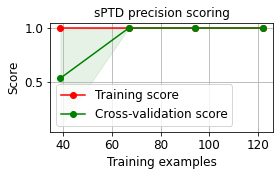

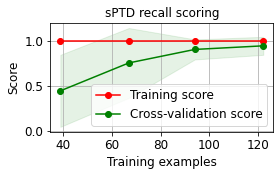

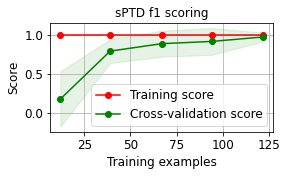

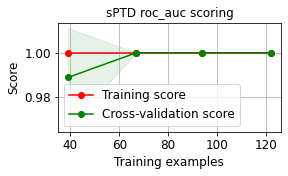

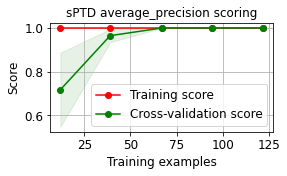

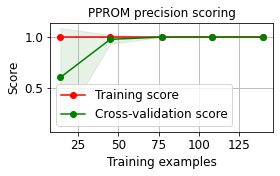

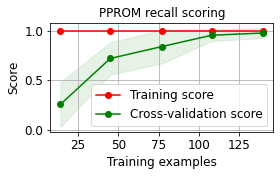

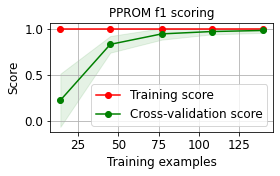

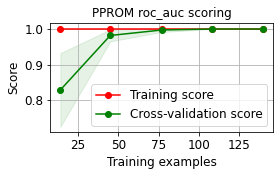

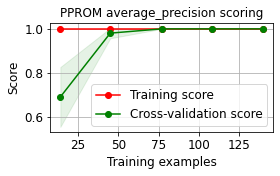

In [32]:
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

model = LogisticRegression(random_state=4)
scoring_metrics = ["precision", "recall", "f1", "roc_auc", "average_precision"]

for metric in scoring_metrics:
    skplt.estimators.plot_learning_curve(model, sPTD_train_test_set, sPTD_outcomes,
                                         cv=5, shuffle=True, scoring=metric,
                                         n_jobs=-1, figsize=(4,2), title_fontsize="large", text_fontsize="large",
                                         title=f'sPTD {metric} scoring');
for metric in scoring_metrics:
    skplt.estimators.plot_learning_curve(model, PPROM_train_test_set, PPROM_outcomes,
                                         cv=5, shuffle=True, scoring=metric,
                                         n_jobs=-1, figsize=(4, 2), title_fontsize="large", text_fontsize="large",
                                         title=f'PPROM {metric} scoring');